In [1]:
%load_ext autoreload
%autoreload 2

/home/jeromeb/micromamba/envs/imaging/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


/media/cephfs2/jparham/Joe for Jerome /SegA Live imaging /20240229_delSegA/CroppedDivisions/01a_delSegA_CM_SyS_reg_Cell_0.tif


/home/jeromeb/micromamba/envs/imaging/lib/python3.11/site-packages/cellpose/resnet_torch.py:276: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filena

['centroid-0', 'centroid-1']
['y', 'x']


Text(0.5, 1.0, '01a_delSegA_CM_SyS_reg_Cell_0')

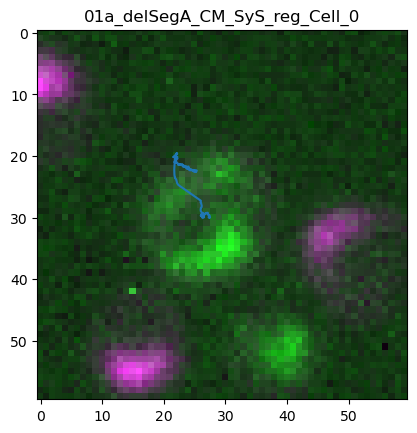

In [2]:
from pathlib import Path
import tifffile
import motionquant as mq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# list files from the src folder
src = Path('/media/cephfs2/jparham/Joe for Jerome /')
filelist = pd.read_csv('filelist.csv')
#src = Path('/media/cephfs2/jparham/For Jerome/Divisions with G2toConstriction/')
dst = Path('./')

# filelist = pd.DataFrame.from_records(
#     [{'path':f,'name':f.stem} for f in src.glob('[!.]*.tif')]
# )
# filelist.head()
filename = filelist['path'].iloc[0]
print(filename)
img, cell_mask, cell_trj, diff, flow, rho, div, blob_labels, blobs_trj = mq.process(Path(filename))
plt.imshow(mq.uv2rgb(img[0]))
plt.plot(cell_trj['centroid-1'], cell_trj['centroid-0'])
plt.title(Path(filename).stem)

In [3]:
results_path = Path('tmp.h5')
if results_path.exists():
    results_path.unlink()
mq.save_result(results_path, Path(filename).stem, img, cell_mask, cell_trj, diff, flow, rho, div, blob_labels, blobs_trj)

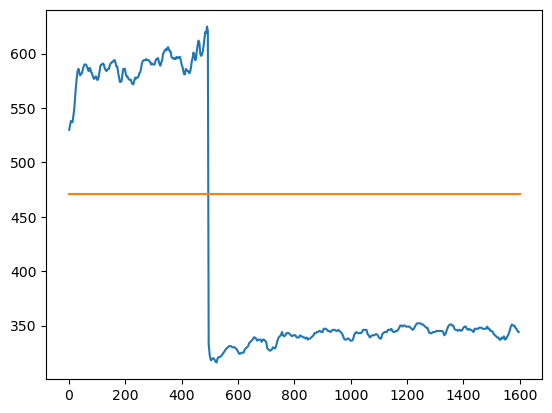

In [2]:
y=cell_trj['area']
y < y.mean()
plt.plot(y)
a=(np.max(y) + np.min(y))/2
plt.plot([0,1600],[a,a])


NameError: name 'x' is not defined

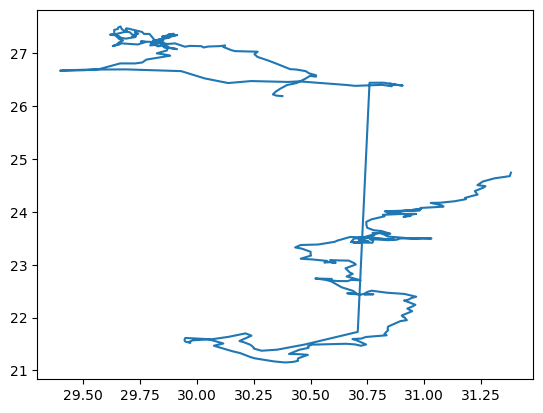

In [4]:
x1 = cell_trj['centroid-0']
y1 = cell_trj['centroid-1']
plt.plot(x1,y1)
plt.plot(x,y)
#plt.imshow(cell_trj['centroid-0'],cell_trj['centroid-1'])

In [ ]:
filelist[filelist['name'] == '01a_DSM639_SyS_CM_Cell_9.tif']

In [ ]:
for t in range(0,300,50):
    plt.imshow(30*labels[t,0] + img[t,0])
    plt.show()


In [ ]:
cell_trj.columns

In [ ]:
# plt.plot(cell_trj['moments_weighted_hu-6'])
plt.plot(cell_trj['mean_intensity'])


Motion analysis

In [7]:
diff = mq.frame_differences(pimg[:,1])
flow = mq.compute_flow(pimg[:,1],2)
rho = mq.momentum(pimg[:-1,1], flow)
div = mq.divergence(rho)
print(diff.shape, flow.shape, rho.shape, div.shape)


(440, 1, 60, 60) (440, 2, 60, 60) (440, 2, 60, 60) (440, 1, 60, 60)


In [38]:
flow_cell = mq.compute_flow(pimg[:,0], 10)

In [ ]:
t = 200
plt.subplot(141)
plt.imshow(np.stack((pimg[t,1],pimg[t,0]/2,pimg[t,1]),2)/50)
plt.axis('off')
plt.subplot(142)
plt.imshow(mq.uv2rgb((flow[t])))
plt.quiver(flow[t,1],flow[t,0])
plt.axis('off')
plt.title('DNA motion')
plt.subplot(143)
plt.imshow(mq.uv2rgb((flow_cell[t])))
plt.quiver(flow_cell[t,1],flow_cell[t,0])
plt.axis('off')
plt.title('Cell motion')
plt.subplot(144)
plt.imshow(mq.uv2rgb((flow[t]-flow_cell[t])))
plt.quiver(flow[t,1]-flow_cell[t,1],flow[t,0]-flow_cell[t,0])
plt.axis('off')
plt.title('DNA - cell motion')

In [ ]:
plt.plot([(np.linalg.norm(x, axis=0) * w).sum() / w.sum() for x,w in zip(flow, cell_mask)])
plt.plot([(np.linalg.norm(x, axis=0) * w).sum() / w.sum() for x,w in zip(flow_cell, cell_mask)])
plt.plot([(np.linalg.norm(x, axis=0) * w).sum() / w.sum() for x,w in zip(flow - flow_cell, cell_mask)])

In [11]:
from skimage import segmentation
from scipy import ndimage as ndi

segmentation.watershed(pimg[0,1], ndi.label(pimg[0,1]>120)[0] )

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

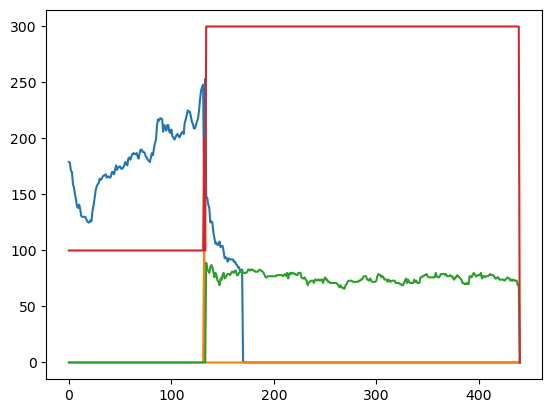

In [13]:
blob_labels, blob_trj = mq.segment_and_track_dna_blobs(pimg[:,1], cell_mask)
import numpy as np
for k in range(1,1+int(blob_labels.max())):
    y = (blob_labels==k).sum(axis=(1,2))
    plt.plot(y)
plt.plot(100*np.max(blob_labels,axis=(-1,-2)))

In [ ]:
blob_trj

In [ ]:
plt.plot(blob_trj['asymmetry'])

In [ ]:
k = 130
plt.subplot(121)
plt.imshow(pimg[k,1])
plt.subplot(122)
plt.imshow(blob_labels[k])
# from scipy import ndimage as ndi
# plt.imshow(ndi.gaussian_filter(ndi.distance_transform_edt(blob_labels[115]),2))
# d = ndi.gaussian_filter(ndi.distance_transform_edt(blob_labels[115]),2)
# plt.imshow(d==ndi.maximum_filter(d,5))

In [ ]:
blob_labels.max()

In [ ]:
mq.save_result("tmp.h5","tmp",img,cell_mask,cell_trj,diff,flow,rho,div,blob_labels,blob_trj)

In [ ]:
pd.read_hdf("tmp.h5","tmp/")

In [ ]:
mq.inspect_result("tmp.h5")

In [ ]:
img, cell_mask, cell_trj, diff, flow, rho, div, blob_labels, blob_trj = mq.load_result("tmp.h5","tmp")

In [ ]:
df = mq.record(filename, img, cell_mask, cell_trj, diff, flow, rho, div, blob_labels, blob_trj)

In [ ]:
df

In [ ]:
plt.imshow(diff[10,0]*cell_mask[10,0])

In [ ]:
plt.imshow(blob_labels[200]==1)

In [ ]:
plt.plot(df["frame"],df["dna blob 1 sum intensity"])

In [ ]:
blob_trj['particle'].unique()

In [ ]:
count, area, asymmetry_area, intensity, asymmetry_int, tmp = mq.blob_area_num_asymmetry(pimg[:,1], mask)

fig,ax = plt.subplots(5,1)
ax[0].plot(count)
ax[1].plot(area)
ax[2].plot(asymmetry_area)
ax[3].plot(intensity)
ax[4].plot(asymmetry_int)

In [ ]:
t = 100
plt.imshow(mask[t,0]+2*tmp[t] + pimg[t,1])

In [ ]:
import matplotlib.pyplot as plt
from skimage import measure

plt.imshow(mq.uv2rgb(img[300]))
for c in measure.find_contours(mask[0, 0], 0.5):
        plt.plot(c[:, 1], c[:, 0], "w")
plt.plot(position[2:,1], position[2:,0])

In [ ]:
fig, ax = plt.subplots(1,6, figsize=(15,5))
mq.figure(ax,"vv",img, mask, position, speed, diff, flow, rho, div)

In [ ]:
mq.strip(filename.stem, img, mask, position, speed, diff, flow, rho, div, "Greys", step=20, quiver=False)
plt.savefig('tmp.pdf')

In [ ]:
import napari
v = napari.view_image(img,channel_axis=1)
v.add_labels(mask.squeeze())
v.add_points(position,ndim=2)

In [ ]:
import colorsys
print(flow.max())

def vec2rgb(x):
    h = (np.arctan2(x[0],x[1])+3.1415) / (2*3.1415)
    v = np.linalg.norm(x,axis=0)    
    y = np.stack((h,v),-1).reshape(x.shape[1]*x.shape[2],2)         
    return np.stack([colorsys.hsv_to_rgb(hv[0],hv[1],1) for hv in y],0).reshape([x.shape[1],x.shape[2],3])

x,y = np.meshgrid(np.linspace(-1,1),np.linspace(-1,1))
plt.imshow(vec2rgb(np.stack((x,y))))
#plt.imshow(vec2rgb(flow[100]))
